In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Score Things
Scorer for non-100% coverage labels borrowed from Snorkel: https://github.com/HazyResearch/snorkel/blob/b047dfb032560584752cb5952a82b90943529209/snorkel/learning/utils.py

From Snorkel Paper Explanation:

*A key takeaway of the following results is that the discriminative model generalizes beyond the heuristics encoded in the labeling functions (as in Example 2.5). In Section 4.1.1, we see that on relation extraction applications the discriminative model improves performance over the generative model primarily by increasing recall by 43.15% on average.*

In [37]:
def binary_scores_from_counts(ntp, nfp, ntn, nfn):
    """
    Precision, recall, and F1 scores from counts of TP, FP, TN, FN.
    Example usage:
        p, r, f1 = binary_scores_from_counts(*map(len, error_sets))
    """
    prec = ntp / float(ntp + nfp) if ntp + nfp > 0 else 0.0
    rec  = ntp / float(ntp + nfn) if ntp + nfn > 0 else 0.0
    f1   = (2 * prec * rec) / (prec + rec) if prec + rec > 0 else 0.0
    return prec, rec, f1

def print_scores(ntp, nfp, ntn, nfn, cov, acc, title='Scores'):
    prec, rec, f1 = binary_scores_from_counts(ntp, nfp, ntn, nfn)
    pos_acc = ntp / float(ntp + nfn) if ntp + nfn > 0 else 0.0
    neg_acc = ntn / float(ntn + nfp) if ntn + nfp > 0 else 0.0
    print("========================================")
    print(title)
    print("========================================")
    #print("Pos. class accuracy: {:.3}".format(pos_acc*100.))
    #print("Neg. class accuracy: {:.3}".format(neg_acc*100.))
    print("Accuracy:            {:.4}".format(acc*100.))
    print("Coverage:            {:.4}".format(cov*100.))
    print("Recall               {:.4}".format(rec*100.))
    print("Precision            {:.4}".format(prec*100.))
    print("F1                   {:.4}".format(f1*100.))
    print("----------------------------------------")
    print("TP: {} | FP: {} | TN: {} | FN: {}".format(ntp, nfp, ntn, nfn))
    print("========================================\n")


def score_binary(test_labels, test_marginals, train_marginals=None, b=0.5,
        set_unlabeled_as_neg=False, set_at_thresh_as_neg=False, display=True):
    """
    Return scoring metric for the provided marginals, as well as candidates
    in error buckets.
    :param test_marginals: array of marginals for test candidates
    :param train_marginals (optional): array of marginals for training
        candidates
    :param b: threshold for labeling
    :param set_unlabeled_as_neg: set test labels at the decision threshold
        of b as negative labels
    :param set_at_b_as_neg: set marginals at the decision threshold exactly
        as negative predictions
    :param display: show calibration plots?
    """
    test_marginal_array = np.zeros(np.shape(test_marginals))
    tp = 0.
    fp = 0.
    tn = 0.
    fn = 0.

    for i in range(len(test_labels)):
        # Handle either a LabelMatrix or else assume test_labels array is in
        # correct order i.e. same order as test_candidates
        test_label = test_labels[i]

        # Bucket the candidates for error analysis
        if test_label != 0:
            if test_marginals[i] > b:
                test_marginal_array[i] = 1.0
                if test_label == 1:
                    tp+=1
                else:
                    fp+=1
            elif test_marginals[i] < b or set_at_thresh_as_neg:
                test_marginal_array[i] = -1.0
                if test_label == -1:
                    tn+=1
                else:
                    fn+=1
        #this is new to count not covered as not labeled
        if test_marginals[i] == b: 
            if test_label == 1:
                fn+=1
            else:
                fp+=1

    #such hack 
    coverage = np.shape(np.where(test_marginals != 0.5))[1]/float(np.shape(np.where(test_marginals != 2))[1])
    accuracy = np.shape(np.where(test_marginal_array == test_labels))[1]/float(np.shape(np.where(test_marginals != 0.5))[1])
    
    print_scores(tp, fp, tn, fn, coverage, accuracy, title="Scores (Un-adjusted)")

    return tp, fp, tn, fn, coverage, accuracy, test_marginal_array

## Load Dataset

In [78]:
dataset='bone_tumor'
filename = 'lr2'
b = 0.5

from data.loader import DataLoader
dl = DataLoader()

if dataset == 'mammogram':
    primitive_matrix, train_primitive_matrix, val_primitive_matrix, \
    [], train_ground, val_ground, [] = dl.load_data(dataset=dataset)
else:
    train_primitive_matrix, val_primitive_matrix, \
    test_primitive_matrix, train_ground, val_ground, test_ground = dl.load_data(dataset=dataset)
#train_marginals = np.load('/dfs/scratch0/paroma/reef/' + dataset + '_reef_' + filename + '.npy')

## Synthesis + Verification
Generate functions based on feedback from the verifier (vary cardinality)

In [79]:
from program_synthesis.heuristic_generator import HeuristicGenerator
validation_accuracy = []
training_accuracy = []
validation_coverage = []
training_coverage = []

training_marginals = []
validation_marginals = []
idx = None
weights = None

hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground, 
                            b=b)
for i in range(3,20):
    print i
    if i == 3:
        hg.run_synthesizer(max_cardinality=2, idx=None, weights=weights, keep=3, model='lr')
    else:
        hg.run_synthesizer(max_cardinality=2, idx=None, weights=weights, keep=1, model='lr')
    hg.run_verifier()
    
    va,ta, vc, tc = hg.evaluate()
    validation_accuracy.append(va)
    training_accuracy.append(ta)
    training_marginals.append(hg.vf.train_marginals)
    validation_marginals.append(hg.vf.val_marginals)
    validation_coverage.append(vc)
    training_coverage.append(tc)
        
    hg.find_feedback()
    idx = hg.feedback_idx
    #weights = hg.vf.find_weighted_vague_points()
    
    if idx == []:
        break

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Visualize Heuristic Behavior

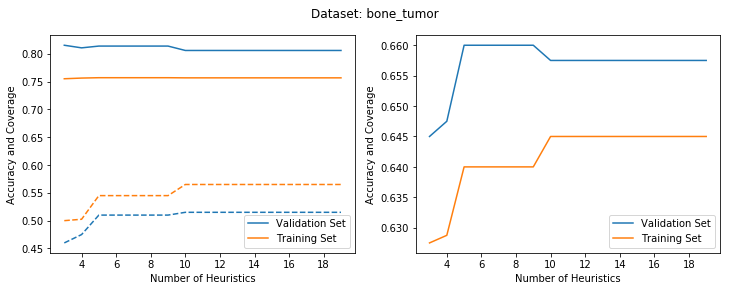

In [80]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(3,20),validation_accuracy, color='C0')
plt.plot(range(3,20),training_accuracy, color='C1')
plt.plot(range(3,20),validation_coverage, color='C0', linestyle='--')
plt.plot(range(3,20),training_coverage, color='C1', linestyle='--')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])

plt.subplot(1,2,2)
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(validation_accuracy,validation_coverage)] 
plt.plot(range(3,20),bm, color='C0')
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(training_accuracy,training_coverage)] 
plt.plot(range(3,20),bm, color='C1')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])
plt.suptitle('Dataset: ' + dataset)

In [81]:
print "Program Synthesis Train Accuracy: ", np.max(training_accuracy[1:])
print "Program Synthesis Train Coverage: ", training_coverage[1:][np.argmax(training_accuracy[1:])]
print "Number of Heuristics: ", np.argmax(training_accuracy[1:])+4

print "Program Synthesis Validation Accuracy: ", np.max(validation_accuracy[3:])

Program Synthesis Train Accuracy:  0.7568807339449541
Program Synthesis Train Coverage:  0.545
Number of Heuristics:  5
Program Synthesis Validation Accuracy:  0.8137254901960784


In [82]:
tp, fp, tn, fn, coverage, accuracy, test_marginal_array = score_binary(val_ground, validation_marginals[4], b=0.5, set_unlabeled_as_neg=False);

Scores (Un-adjusted)
Accuracy:            81.37
Coverage:            51.0
Recall               29.67
Precision            33.75
F1                   31.58
----------------------------------------
TP: 27.0 | FP: 53.0 | TN: 56.0 | FN: 64.0

